# Airbus Ship Detection

EE 435: Deep Learning Foundations from Scratch \
Northwestern Univertiy Winter 2020

## Memebers
* Blaine Rothrock (`BRY4768`)
* Ilan Ponsky (`IPW1530`)
* Will Dong (`WDG4518`)

## Code

This document is intenially missing components of our implementation and is intended as a over view what we did and learned from the project. For all notebooks and code, see our public [git repo](https://github.com/blainerothrock/airbus-ship-detection)

## Overview

Our group was interested in applying knowledge from this course to training TensorFlow models and getting a better understanding of neural networks involved in image processing. In order to learn about this process in an organized and efficient way, we utilized a closed Kaggle competition that centered around our topic of image processing with neural networks. The competition we used was the [Airbus Ship Detection Challenge](https://www.kaggle.com/c/airbus-ship-detection). The goal of the Kaggle competition was for participants to be able to build a model that could “detect all ships in satellite images as quickly as possible.”

The specific goals we wanted to hit for our Deep Learning from Scratch final project were to: 
* Build a binary classifier model to gain a basic understanding of Tensorflow and how to build models in TensorFlow.
    - The objective of the binary classifier model is to output whether an image contained a ship or not utilizing optimazation techniquies in TensorFlow.
* Explore and implement a U-net model for image segmentation. 
    - U-Net models are the current state-of-art for image segmentation and where most started for this competition.
    - This is a heafty goal given the data size of ~40GB of images and the time it takes to training this complex model. Our goal is to build a model, attempt at training, and gain a understanding of the U-Net architechure.
    - To accomplish this, we utilized the notebook of Kevin Mader on Kaggle which served as an excellent foundation to get started with implementing the mentioned goals

## Understanding the Data

The main reason we choose to use Kaggle is because the data is easily obtained and well organized. The data came in the form of a set of training and testing images then a `.csv` file containing image names and encoded pixels. Each row mapped to a image and the encoded pixel column represetned a bounding box around a ship in a image. Most images have no ships and some have multiple, up to 15.

First we are able to explore the segment file: `train_ship_segmentations_v2.csv`

In [4]:
import os
import pandas as pd

ship_dir = '../data/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
masks.head(5)

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [7]:
# TODO: Add samples images from the dataset (at least 1 with a ship)

Using code from a getting started notebook on the kaggle project, we are able to see the masks. below we are looking at an image with the max number of ship (15). This code checks the given encoding and decoding methods

Check Decoding->Encoding RLE_0: 15 -> RLE_1: 5


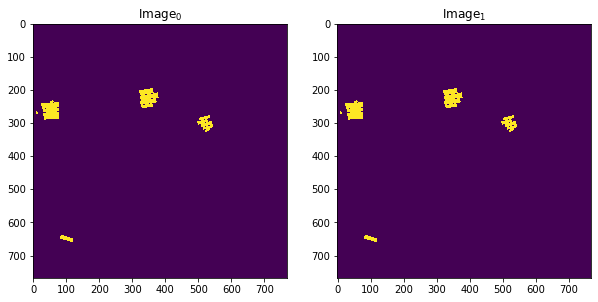

In [6]:
import matplotlib.pyplot as plt
from util import masks_as_image
from util import multi_rle_encode

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="11f3bae66.jpg"')['EncodedPixels'] # 15 ships in the image
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

## Binary Classifier

The objective of our binary classifier is to gain a understanding of building models in Tensorflow and apply optimation problems learned in this class to TensorFlow. Out Binary classifier will use the data from the Airbus challenge and instead of use image segmentation to predict where a ship is in a image, it will simply detect if there is a ship in the image. For this, we will use a CNN model and explore training and optimzation in Tensorflow.

### Adjust the data for image classification.

The first step to update the dataframe for the classification. To start we have pixel encoding and we need to translate the to classifications of `ship` and `no_ship`. When a image has mutliple ships there are multiple entries in the dataframe, so they will need to be flattened aswell. Below is the code we used to to that:

In [11]:
# populate a ship count (0 or 1)
masks['ship_count'] = masks['EncodedPixels'].map(lambda x: 1 if isinstance(x, str) else 0)
masks.sample(10)

# aggregate ship images and sum number of ships. images with multiple ships will have multiple rows
unique_masks = masks.groupby('ImageId').agg({'ship_count': 'sum'}).reset_index()
unique_masks['file_size_kb'] = unique_masks['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024 if os.path.exists(os.path.join(train_image_dir, c_img_id)) else 0.0)
unique_masks = unique_masks[unique_masks['file_size_kb']>50]
unique_masks.drop(['file_size_kb'], axis=1, inplace=True)

# create a string class column, used later for the build in image generator
unique_masks['has_ship'] = unique_masks['ship_count'].map(lambda x: 1 if x > 0.0 else 0)
unique_masks['class'] = unique_masks['ship_count'].map(lambda x: 'ship' if x > 0.0 else 'no_ship')
unique_masks.sample(5)

,ImageId,ship_count,has_ship,class
192265,ff98308ec.jpg,0,0,no_ship
182939,f34683d2a.jpg,0,0,no_ship
132205,afbbeef01.jpg,3,1,ship
49326,41b58d393.jpg,0,0,no_ship
16104,156cd60c2.jpg,0,0,no_ship


## Binary Classification Training & Results

### Baseline CNN model

To start and to get familiar with TensorFlow, we started with a very simple CNN model build in TensorFlow2 (Keras). This model includes 3 hidden convolution layer with 16, 32 and 64 nodes respectively. Each convoluational layer has a max pooling layer with the deful `(2, 2)` pool sizing. Our image generator reduced the size of the ships from `(768, 768, 3)` to `(256, 256, 3`) to reduce training times. The model uses the standard Adam optimzer with default settings.

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

The results of this model gives us a baseline for optimzation. 

<img src="images/binary_classifier_results3.png" alt="initial binary classifier" style="float: left; height: 300px;"/>

The model doesn't perform horribly, but we can clearly see some issues with overfitting in the training set and the validation accurarcy doesn't improve much after the first few epochs. In the next few iterations we will try and improve this by adding some common techiques to reduce overflow and produce better results.

### Iterations from the baseline

This is a consolidation to reduce the size of our report. We tired a few iterations of the following:

* **Undersamplying the data** -- reduce the training data to have a more even distrubution of the binary classes.
* **Augmenting the data** -- Randomly flipping and slightly roatating training images to avoid overfitting
* **Momentum/Adom optimization** -- Adding beta values to the Adam optimzier
* **Learning Rate Reduction on Plateau**: When the accurarcy of loss of validation flatlines, reduce the learning rate by a factor
* **Drop out/Larget Model** -- Randomly dropping nodes in the model, this again can avoid overfitting and in some cases improve the model

#### 1 . Undersampling the data
The first thing we can do is undersample the training data. We do this because the distrubution is greatly inbalanced. Threre are many more images with no ships and therefore our model will be bias to guess no ships. Predicting no ships gives the model about 80% accurarcy given the distrbution:

In [23]:
no_ship_count = unique_masks[unique_masks['class'] == 'no_ship'].shape[0]
ship_count = unique_masks[unique_masks["class"] == 'ship'].shape[0]
print('no_ship count: {}\nship count:     {}\n'.format(no_ship_count, ship_count))
no_ship_idxs = unique_masks[unique_masks['class'] == 'no_ship'].sample(no_ship_count - ship_count - 5000).index
balanced_train_df = unique_masks.drop(no_ship_idxs, inplace=False)
no_ship_count = balanced_train_df[balanced_train_df['class'] == 'no_ship'].shape[0]
print('balanced no ship count: {}'.format(no_ship_count))

no_ship count: 149293
ship count:     41996

balanced no ship count: 46996


### 2. Augmenting the data
Using the built in image generators provided by Tensorflow2 we can easily augment the data to avoid overfitting. We did this by adding horizontal flip and roatation to our images. We did not want to add any transformations such as stretching because of the nature of our data. The boats are very small and generally the same shape, so altering the structure of the image, we believe, would be detramental. The following in the image generator we used to do this:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, # rotate +/- 10 degrees
    horizontal_flip=True # flip the image
)

train_data_gen = train_image_generator.flow_from_dataframe(
    balanced_train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True
)

### 3. Adam Optimization
We also played around with the Adam optimizer adding beta values. We did not see any drastic changes in the first few epochs so we kept the default values for beta.

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=10e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07,
    name='Adam'
)

### 4. Learning Rate Reduction on Plateau
TensorFlow provides a number of built in callbacks that can be used to help train your model. We used a few to experienment including TensorBoard, Early Stopping, Reduce Learning Rate on Plateu, and Checkpoints. Early stopping is extremely helpful when training on instances that cost money (assuming you know when the model stops). Early stoping will measure a metric of the model, usually a validation metric, and stop the model if that metric doesn't improve for some number of epochs. Reduce Learning Rate on Plateau is also very useful. Instead of adjust the learning rate linearly or based on a aribritrary epoch threashold, this callback will start to reduce the learning rate when the model stops learning. These callbacks are calculated after each epoch and action are taking on training if needed. Engineers can also create custom callbacks to monitor or report on the training. 

In [ ]:
reduceLROnPlateautf = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto',
    min_delta=0, 
    cooldown=0, 
    min_lr=0
)

earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    mode='max',
    baseline=None, 
    restore_best_weights=False
)

### 5. Dropout & Larger Model
Applying dropout to the model with the keras `Dropout()` keras layer helper is a way to reduce overfitting the training data. Dropout is a techique that randomly inhibits nodes in the network 

Below is the final model we attamped, which is slightly larger than the baseline (4 convolution layers with 32, 32, 64, 64 nodes), and adds dropout at 20%.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Results of optimization
We were able to reduce the about of overfitting with our data, but we were never able to get the model to learn past about the 92% validation accurarcy. We trained about 10 iterations of the model, each taking about 70 - 90 minutes to complete. With this we determine that the data may not be as clean has we hoped. In a few cases we did see  images with mis numbered boats, or that were clearly generated (repeated mirror images, etc).

Below is the learning curve from our more complex model with dropout also utilizing the learning rate reduction callback and data augmentation. The overfitting has clearly improved from the baseline, but there is no 

<img src="images/dropout_binary.png" alt="initial binary classifier" style="float: left; height: 300px;"/>

## U-Net Model

Building upon our binary classification experiments, we wanted to implement a deep learning architecture that would actually be able to not just identify whether an image had a ship or not, but to also identify the number of ships in the image. To accomplish this, we chose to implement a U-Net architecture. 

The U-Net was first introduced in 2015 as a convolutional neural network developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The full paper for the original U-Net can be found [here.](https://arxiv.org/abs/1505.04597) 

The reason behind choosing the U-Net architecture is partly because the U-Net is a very popular end-to-end encoder-decoder network for image segmentation. In our implementation, the U-Net detects individual objects (ships) and predicts their masks.


### U-Net Architecture

<img src="https://miro.medium.com/max/921/0*o1n7BqtOj9_xLD_x.png" alt="initial binary classifier" style="float: left; height: 300px;"/>

The U-Net model is shaped like a "U", hence its name. The model architecture is symmetric and consists of two major parts - a contracting path and an expansive path. Our implementation is given in the code chunk below, which utilizes the Keras Tensorflow library. The imported functions can be found in our utility file.

```python
from util import conv_down #These auxiliary functions are in our util file
from util import conv_up
from util import pool

d1 = conv_down(8, input_img, name='d1')
dp1 = pool(d1, name='d1')
d2 = conv_down(16, dp1, name='d2')
dp2 = pool(d2, name='d2')
d3 = conv_down(32, dp2, name='d3')
dp3 = pool(d3, name='d3')
d4 = conv_down(64, dp3, name='d4')
dp4 = pool(d4, name='d4')
b = conv_down(128, dp4, name='b')
u1 = conv_up(64, b, d4, name='u1')
u2 = conv_up(32, u1, d3, name='u2')
u3 = conv_up(16, u2, d2, name='u3')
u4 = conv_up(8, u3, d1, name='u4')

out = Conv2D(1, (1, 1), activation='sigmoid', name='out_conv1')(u4)
out = Cropping2D((unet_params.edge_crop, unet_params.edge_crop), name='out_crop')(out)
out = ZeroPadding2D((unet_params.edge_crop, unet_params.edge_crop), name='out_pad')(out)

unet = models.Model(inputs=[input_img], outputs=[out], name="UNet")
```

### Contraction

During the contraction phase, each layer typically undergoes the same path - two convolution layers, followed by a max pooling layer, and a dropout layer. In our implementation, we don't use a dropout layer.

We first start on the left side of the "U", where we contract the input images. The first part of our implementation is:

```python
d1 = conv_down(8, input_img, name='d1')
dp1 = pool(d1, name='d1')
```
Where conv down and pool are:


```python
def conv_down(filter_, in_layer, name, kernel=(3, 3), activation='relu', padding='same'):
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv1')(in_layer)
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv2')(l)
    return l

def pool(in_layer, name, pool_size=(2, 2)):
    return MaxPooling2D(pool_size, name=name+'_pool')(in_layer)
```


Here, the "d1" variable consists of two convolutional layers (since we are doing convolutions on a 3x3 basis), which serve to increase the depth of the input image. This is followed by a max pooling process which essentially cuts the size of the image in half. In our implementation, the number of channels start at 8, and increase to 16, while the pixel size of the image goes from 586x568 to 284x284.

This process is then repeated three more times

```python
d2 = conv_down(16, dp1, name='d2')
dp2 = pool(d2, name='d2')
d3 = conv_down(32, dp2, name='d3')
dp3 = pool(d3, name='d3')
d4 = conv_down(64, dp3, name='d4')
dp4 = pool(d4, name='d4')
```
until the input image reaches the middle/lowest layer. The image is then run through two more convolutional layers, but no max pooling layer, since the next step is expansion. At this point, the image has been resized to 28x28x128, and is ready to get upsized to its original size.

### Expansion

The flow of an expansion layer consists of upsampling the input image and concatenating it with the corresponding image from the contracting path. In our implementation, it looks like this:


```python
u1 = conv_up(64, b, d4, name='u1')
u2 = conv_up(32, u1, d3, name='u2')
u3 = conv_up(16, u2, d2, name='u3')
u4 = conv_up(8, u3, d1, name='u4')
```

Where conv_up is:


```python
def conv_up(filter_, in_layer, conv_down_layer, name, upsample_size=(2, 2), kernel=(3, 3), activation='relu', padding='same'):
    l = UpSampling2D(upsample_size, name=name+'_upsample')(in_layer)
    l = concatenate([l, conv_down_layer], name=name+'_concat')
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv1')(l)
    l = Conv2D(filter_, kernel, activation=activation, padding=padding, name=name+'_conv2')(l)
    return l
```

Here, we apply the UpSampling2D function from Keras, which essentially performs some padding on the original image, followed by a convolution operation (transposed convolution). After upsampling, the image size is doubled, and the image is then concatenated with the corresponding image from the corresponding contraction layer. That is, in the first layer the image is upsized from 28x28x128 to 56x56x64, and concatenated with the 56x56x64 image in the contraction layer (u1 and d4 in the first case) to make an image of size 56x56x128. By concatenating the images, information from the previous layers is combined to obtain a more precise prediciton. This process is again repeated 3 times to preserve symmetry, and trivially, an unsymmetric model would not be able to perform concatenation in the expansion phase.

## Output Layer

Once the image has gotten to the top layer in the expansion phase, the final step in the model requires us to reshape the image to satisfy the prediction requirements.

```python
out = Conv2D(1, (1, 1), activation='sigmoid', name='out_conv1')(u4)
out = Cropping2D((unet_params.edge_crop, unet_params.edge_crop), name='out_crop')(out)
out = ZeroPadding2D((unet_params.edge_crop, unet_params.edge_crop), name='out_pad')(out)
```


The output layer is a convolution layer with a single filter of size 1x1. Here, we add additional padding to fit the pixel size requirements.

### U-Net Results



## Extra


Based on the kaggle challenge [Airbus Ship Detection Challenge](https://www.kaggle.com/c/airbus-ship-detection/overview). This challenge uses satellite images to detect if a image has ships and draw a box (mask) around the ship. This challenge contains ~40GB of data and the training size is a little out of scope for this project, so we approaching it with two goals:
1. Training a binary classifier to classify images that contain ship(s)
2. Explore the state-of-the-art approach to this model, U-Net
    - Goal is to follow the baseline notebook submission and understand the architechure. 
    
    
The objective of a binary classifier model is predicting on the definition of binary classification which is the task of classifying a set of data into two distinct groups. The entire premise of creating a binary classification neural network model is to end up with an output layer which has 2 classes (1 or 0). In our case, 1 signifying that an image contains a ship while 0 indicating that the image does not contain an image of a ship. Much like any other neural network, this model requires an input layer, hidden layers, and an output layer. Our images had to be flattened to create a vector rather than a matrix for each image which was fed into the input layer of our model. After being multiplied by a bias and weights, the resulting vectors are run through an activation function which then propagates forwards. This model also utilizes cross entropy as its cost function as it is well suited to support a classification problem such as ours.

